In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# install dependencies for reading .dcm files
!pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.3 MB/s eta 0:00:00


In [3]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# Manage files
from PIL import Image
import pydicom

# Others
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

!pip install -qU python-gdcm pydicom pylibjpeg

In [4]:
# Progress bar library imports
from tqdm.notebook import tqdm, trange

# Parallel processing library imports
from joblib import Parallel, delayed

import shutil

In [5]:
# set random seed
np.random.seed(2023)

## Read trainning data

In [6]:
filepath = '/kaggle/input/rsna-breast-cancer-detection/train.csv'
train_data = pd.read_csv(filepath)
train_data[train_data.cancer == 1].sample(5)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
40111,1,53343,463687047,L,CC,77.0,1,1,1,0.0,0,C,49,False
2730,2,12918,835777184,L,CC,58.0,1,1,1,NaN,0,NaN,29,False
26683,1,38537,1655223848,L,CC,61.0,1,1,1,0.0,0,A,49,False
3502,1,13756,1210098281,L,CC,71.0,1,1,0,0.0,0,B,49,False
4578,2,14962,1306633485,R,CC,46.0,1,1,0,NaN,0,NaN,29,False


In [7]:
filepath_test = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
test_data = pd.read_csv(filepath_test)
test_data.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [8]:
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/'
test_path = '/kaggle/input/rsna-breast-cancer-detection/test_images/'

In [9]:
# collect all image path into a list
all_img_path = []
base_path = '/kaggle/input/rsna-breast-cancer-detection/'
training_images_per_patient = os.path.join(base_path, 'train_images/')
patient_ids = os.listdir(training_images_per_patient)
for patient in tqdm(patient_ids):
    path = os.path.join(training_images_per_patient, patient)
    patient_imgs = os.listdir(path)
    for img_name in patient_imgs:
        final_path = os.path.join(path, img_name)
        all_img_path.append(final_path)

  0%|          | 0/11913 [00:00<?, ?it/s]

In [10]:
train_data['file_path'] = train_data['patient_id'].astype(str) + '/' + train_data['image_id'].astype(str) + '.dcm'
image_paths = train_data['file_path'].tolist()

In [11]:
cancer_data = train_data[train_data.cancer == 1]
cancer_path = cancer_data.file_path.tolist()
cancer_img_path = [train_path+c for c in cancer_path]
len(cancer_img_path)

1158

In [12]:
def find_image_id(img_path):
    path_array = re.split('/', img_path)
    image_id = int(path_array[-1][:-4])
    return image_id

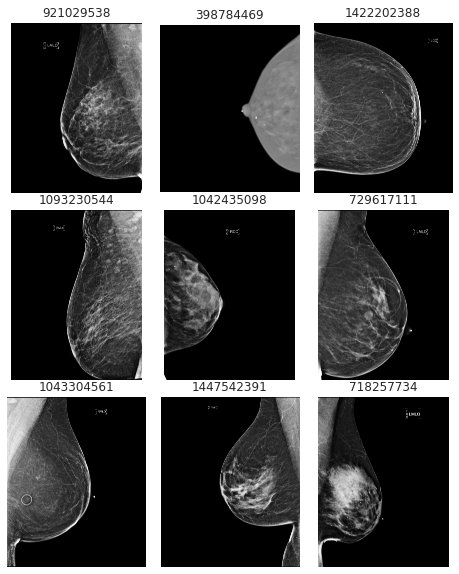

In [13]:
# display raw .dcm images before any preprocessing
n = 3
random_images_path = np.random.choice(all_img_path, size=n*n)
fig, ax = plt.subplots(n, n, figsize=(8, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for (i, a) in enumerate(ax.flat):
    ds = pydicom.dcmread(random_images_path[i])
    id_ = find_image_id(random_images_path[i])
    a.grid(False)
    a.axis('off')
    a.set_title(id_)
    a.imshow(ds.pixel_array, cmap='gray')

In [14]:
train_data[train_data.image_id==2099741121]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,file_path
20505,2,31741,2099741121,L,CC,60.0,0,0,0,NaN,0,NaN,29,False,31741/2099741121.dcm


In [15]:
import cv2

In [16]:
# find a random image
# image_path = np.random.choice(all_img_path)
# i_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/31741/2099741121.dcm'
i_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/47128/1726612128.dcm'

In [17]:
# convert image to a numpy array
def convert_to_numpy(img_path):
    ds = pydicom.dcmread(img_path)
    image = ds.pixel_array
    image = np.asarray(image, np.float64)

    return image

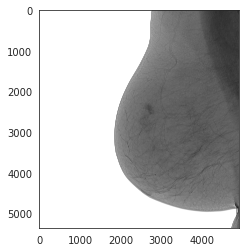

In [18]:
np_img = convert_to_numpy(i_path)
plt.imshow(np_img, cmap='gray');

In [19]:
# invert color scheme to a consistent state
def invert(image: np.ndarray):
    mean_pixel = np.mean(image)
    max_pixel, min_pixel = np.max(image), np.min(image)
    pixel_median_range = (max_pixel - min_pixel) / 2
    if mean_pixel > pixel_median_range:
        image = max_pixel - image + min_pixel
    return image

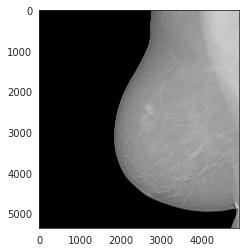

In [20]:
inv_img = invert(np_img)
plt.imshow(inv_img, cmap='gray');

In [21]:
# flip all images to left
def flip_to_left(image):
    pixel_dist = np.sum(image, axis=0)
    if pixel_dist[-10] > pixel_dist[10]:
        return np.flip(image, axis=1)

    return image

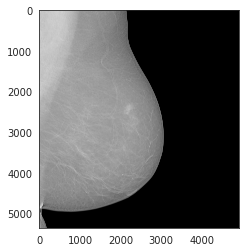

In [22]:
flip_img = flip_to_left(inv_img)
plt.imshow(flip_img, cmap='gray');

In [23]:
def crop(img):
    """
    Crop ROI from image.
    """
    height, width = img.shape
    img = img[int(0.1*height):int(0.9*height), int(0.05*width):int(0.95*width)] 
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img.astype(np.uint8),(5,5),0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
#     x, y, w, h = int(1.1*x), y, int(0.9*w), h
#     x, y, w, h = int(1.1*x), int(1.2*y), int(0.9*w), int(0.8*h)
    return img[y:y+h, x:x+w], breast_mask[y:y+h, x:x+w]#, mask[y:y+h, x:x+w]

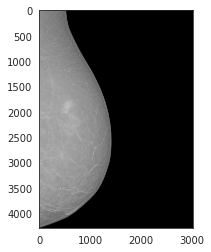

In [24]:
crp_img, crp_mask = crop(flip_img)
plt.imshow(crp_img, cmap='gray');

In [25]:
def truncation_normalization(img, mask):
    """
    Pixel clipped and normalized in breast ROI
    """
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

In [26]:
def clahe(img, clip):
    #contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [27]:
def synthesized_image(img_path):
    """
    Merging of truncation_normalization + clahe1 + clahe2
    """
    np_img = convert_to_numpy(img_path)
    img_inv = invert(np_img)
    img_flip = flip_to_left(img_inv)
    nrm_img = crop(img_flip)
    normalized = truncation_normalization(nrm_img[0], nrm_img[1])

    cl1 = clahe(normalized, 1.0)
    cl2 = clahe(normalized, 2.0)

    synthetized = cv2.merge((np.array(normalized*255, dtype=np.uint8),cl1,cl2))
    return synthetized

In [28]:
def pixel_density(img):
    density = np.sum(img, axis=0)
    density /= np.max(density)
    return density

/kaggle/input/rsna-breast-cancer-detection/train_images/64437/526841535.dcm


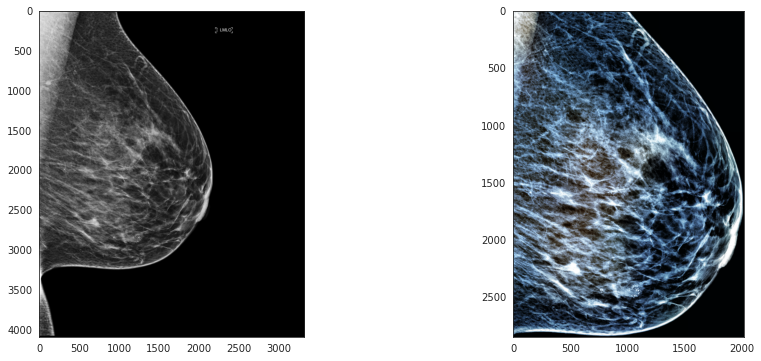

In [29]:
image_path = np.random.choice(cancer_img_path)
# image_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/36660/498444217.dcm'
# image_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/49485/109045962.dcm'
# image_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/47128/1726612128.dcm'
print(image_path)
img = synthesized_image(image_path)
fig,ax = plt.subplots(1,2, figsize=(15,6))
original_img = convert_to_numpy(image_path)
ax[0].imshow(original_img, cmap='gray')
ax[1].imshow(img);

In [30]:
train_data[train_data.image_id==1726612128]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,file_path
34624,2,47128,1726612128,R,MLO,63.0,1,1,1,NaN,0,NaN,29,False,47128/1726612128.dcm


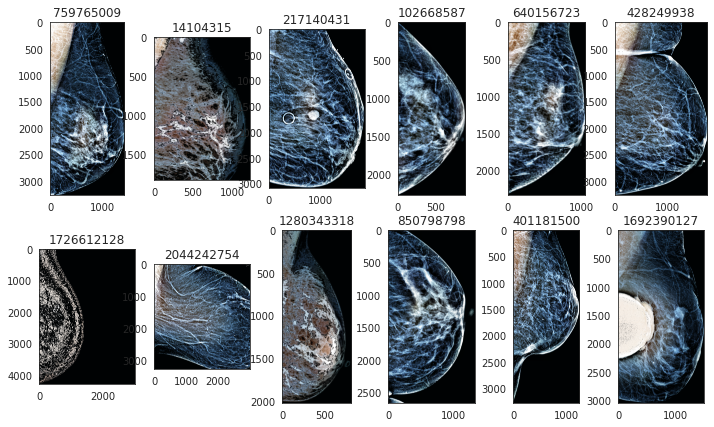

In [31]:
random_img_path = np.random.choice(cancer_img_path, size=12)
fig, ax = plt.subplots(2, 6, figsize=(12,7))
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
for (i, a) in enumerate(ax.flat):
    id_ = find_image_id(random_img_path[i])
    final_image = synthesized_image(random_img_path[i])
    a.grid(False)
    a.set_title(id_)
    a.imshow(final_image)

## make balanced dataset

In [32]:
train_data_malignant = train_data[train_data['cancer']==1]
train_data_malignant.shape

(1158, 15)

In [33]:
train_data_benign = train_data[(train_data['cancer']==0) & (train_data['difficult_negative_case']==False)]
train_data_benign.shape

(45843, 15)

In [34]:
# remove patients with implant
train_data_benign_with_no_implant = train_data_benign[train_data_benign['implant'] != 1]
train_data_benign_with_no_implant = train_data_benign_with_no_implant.sample(frac=0.026, random_state=41)
train_data_benign_with_no_implant.shape

(1161, 15)

In [35]:
dataset = pd.concat([train_data_malignant, train_data_benign_with_no_implant])
# shuffle dataset
dataset = dataset.sample(frac=1)
dataset.shape

(2319, 15)

In [36]:
dataset.head(3)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,file_path
51474,2,65492,1186509485,L,MLO,59.0,1,1,1,NaN,0,NaN,48,False,65492/1186509485.dcm
43118,1,56491,734300452,R,MLO,52.0,1,1,1,0.0,0,C,49,False,56491/734300452.dcm
42344,1,5568,773252230,R,CC,63.0,0,0,0,NaN,0,C,49,False,5568/773252230.dcm


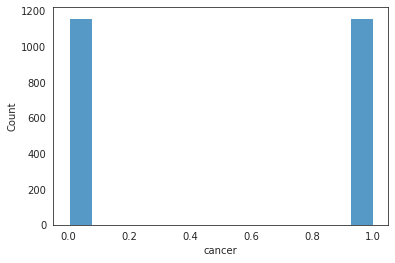

In [37]:
sns.histplot(dataset['cancer']);

In [38]:
dataset['file_path'] = dataset['patient_id'].astype(str) + '/' + dataset['image_id'].astype(str) + '.dcm'
image_paths = dataset['file_path'].tolist()
dataset.head(2)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,file_path
51474,2,65492,1186509485,L,MLO,59.0,1,1,1,NaN,0,NaN,48,False,65492/1186509485.dcm
43118,1,56491,734300452,R,MLO,52.0,1,1,1,0.0,0,C,49,False,56491/734300452.dcm


In [39]:
root_dir = '/kaggle/working/cancer_dataset/'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)
    
def save_image(path):
    base_dir = '/kaggle/input/rsna-breast-cancer-detection/train_images/'
    actual_path = base_dir + path
    final_image = synthesized_image(actual_path)
    image_id = find_image_id(path)
    im = Image.fromarray(final_image.astype(np.uint8))
    im.save(root_dir + str(image_id) + '.jpeg')

os.makedirs(root_dir)

In [40]:
'''
uncomment and run this cell to save 21419 images(!!!) into the directory
beaware it might take 3-4 hours to complete
at your own risk :) :')
'''
# save = Parallel(n_jobs=4)(delayed(save_image)(path) for path in tqdm(image_paths, total=len(image_paths)))

"\nuncomment and run this cell to save 21419 images(!!!) into the directory\nbeaware it might take 3-4 hours to complete\nat your own risk :) :')\n"

In [41]:
# to make a zip folder of the images
# shutil.make_archive('cancer_dataset', 'zip', '/kaggle/working/cancer_dataset')

In [42]:
# from IPython.display import FileLink
# FileLink(r'cancer_dataset.zip')